In [4]:
import pandas as pd
import seaborn as sns
import re,json,nltk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.filterwarnings("ignore")
import os

In [5]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [6]:

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/3-classes-bangla-sa/3_classes_Bert_Preprocessed__Dataset.xlsx


In [7]:
df=pd.read_excel('/kaggle/input/3-classes-bangla-sa/3_classes_Bert_Preprocessed__Dataset.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15728 entries, 0 to 15727
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  15728 non-null  int64 
 1   Data        15728 non-null  object
 2   Label       15728 non-null  int64 
 3   Token       15728 non-null  object
 4   Token_ID    15728 non-null  object
dtypes: int64(2), object(3)
memory usage: 614.5+ KB


In [8]:
df.head()

,Unnamed: 0,Data,Label,Token,Token_ID
0,4032,এক মাস সেহেরি খাইয়া রোজা রাহা সোজা,1,"['এক', 'মাস', 'সে', '##হের', '##ি', '[UNK]', '...","[788, 1293, 809, 2685, 416, 1, 12209, 3462, 41..."
1,3587,ভাই আমাদের মাতৃভুমিটা এত সুনদর,1,"['ভাই', 'আমাদের', 'মাতৃ', '##ভু', '##মিট', '##...","[1352, 1029, 6563, 12357, 12290, 415, 1284, 36..."
2,8968,জানুয়ারীতে কেন ঐ সময় স্পেশাল কি,1,"['[UNK]', 'কেন', 'ঐ', '[UNK]', 'স্পেশাল', 'কি']","[1, 1107, 218, 1, 10225, 817]"
3,95,তোরা কখন কাচা রসুন চাবিয়ে খেয়ে দেখেচিস,2,"['তোরা', 'কখন', 'কাচা', 'রসুন', '[UNK]', '[UNK...","[5712, 1394, 30306, 18173, 1, 1, 1172, 2408, 417]"
4,1163,হ্যাঁ হ্যাঁ হ্যাঁ হ্যাঁ জীবন টা বেদনা,2,"['হ্যাঁ', 'হ্যাঁ', 'হ্যাঁ', 'হ্যাঁ', 'জীবন', '...","[2154, 2154, 2154, 2154, 1537, 1632, 10018]"


<AxesSubplot:xlabel='Label', ylabel='count'>

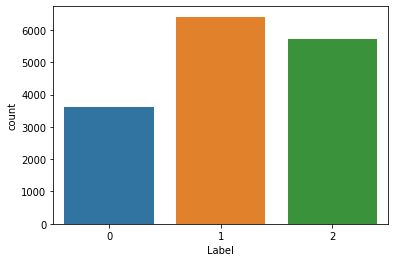

In [9]:
sns.countplot(df['Label'])

In [10]:
df.Label.value_counts(), len(df)

(1    6410
 2    5709
 0    3609
 Name: Label, dtype: int64,
 15728)

In [11]:
df=df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [12]:
df.reset_index(drop=True, inplace=True)

In [13]:
df_filtered = df[df['Label'] > 0]
df=df_filtered

<AxesSubplot:xlabel='Label', ylabel='count'>

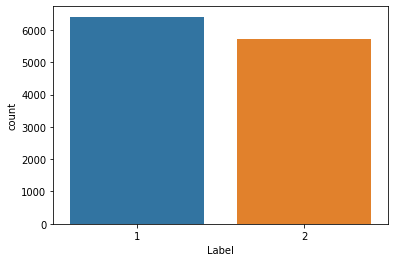

In [14]:
sns.countplot(df['Label'])

In [15]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear','sigmoid'],
            'gamma':['auto','scale'],
            'decision_function_shape':['ovo', 'ovr']

        }  
    },
    
    'decision tree':{
        'model':DecisionTreeClassifier(),
        'params':{
            'max_depth' : [125,500,700,900],
            'max_features' : ["sqrt","log2"],
            'min_samples_split' : [15,55,95],
            'criterion':['entropy']
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10,25],
            #'weights': ['uniform','distance']
            
        }
    },
    'multinomial naive bayes':{
        'model':MultinomialNB(),
        'params':{
            'alpha':[.10,.25,.40,.75,.90]
        }
    },
    'k nearest neighbors':{
        'model':KNeighborsClassifier(),
        'params':{
            'n_neighbors': [3,4,5,6,7],
            'weights': ['uniform','distance'], 
            'algorithm' : ['ball_tree', 'kd_tree', 'brute']

            
        }
    },
    'Stochastic Gradient Descent':{
        'model':SGDClassifier(),
        'params':{
            'loss':['log'],
            'penalty':['l2', 'l1', 'elasticnet'], 
            'alpha':[.0001,.0005,.0009,.0012]

        }
    }
}

In [16]:
scores_function = ['precision_macro','recall_macro','f1','accuracy']

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
x_bow = vect.fit_transform(df['Token'])
x_train, x_test, y_train, y_test = train_test_split(x_bow,df['Label'], test_size=0.2, random_state=42)

In [15]:
categories=[1,2]

In [ ]:
scores = []
for model_name, mp in model_params.items():
  for score in scores_function:
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, scoring=score)
    clf.fit(x_train,y_train)
    
  scores.append({
            'model': model_name,
            'best_params': clf.best_params_,
            'precision':precision_score(y_test,clf.predict(x_test),average='macro'),
            'recall':recall_score(y_test,clf.predict(x_test),average='macro'),
            'f1':f1_score(y_test,clf.predict(x_test),average='macro'),
            'accuracy':accuracy_score(y_test,clf.predict(x_test))
        })
    
df_score = pd.DataFrame(scores,columns=['model','best_params','precision','recall','f1','accuracy'])
df_score.to_excel('2 classes BOW ML parameters.xlsx')
df_score.sort_values(by=['accuracy'],ascending=False) 



In [ ]:
y_pred=clf.best_estimator_.predict(x_test)
y_pred = y_pred.reshape(-1,1)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greys')

ax.set_title('BOW ML Bigram Confusion Matrix for Binary class');
ax.set_xlabel('Predicted Sentiment Category')
ax.set_ylabel('Actual Sentiment Category ');

ax.xaxis.set_ticklabels(['Postive', 'Negative'])
ax.yaxis.set_ticklabels(['Postive', 'Negative'])
sns.set(color_codes=True)
sns.set(font_scale=1.3)
plt.savefig('BOW ML Bigram Confusion Matrix for Binary class', bbox_inches = "tight")
plt.show()

In [17]:
#TF-IDF unigram
tfidf_unigram = TfidfVectorizer(use_idf=True,tokenizer=lambda x: x.split()) 
x_tfidf_unigram= tfidf_unigram.fit_transform(df['Token'])
x_train, x_test, y_train, y_test = train_test_split(x_tfidf_unigram,df['Label'], test_size=0.2, random_state=42)

In [18]:
scores = []
for model_name, mp in model_params.items():
  for score in scores_function:
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, scoring=score)
    clf.fit(x_train,y_train)
    
  scores.append({
            'model': model_name,
            'best_params': clf.best_params_,
            'precision':precision_score(y_test,clf.predict(x_test),average='macro'),
            'recall':recall_score(y_test,clf.predict(x_test),average='macro'),
            'f1':f1_score(y_test,clf.predict(x_test),average='macro'),
            'accuracy':accuracy_score(y_test,clf.predict(x_test))
        })
    
df_score = pd.DataFrame(scores,columns=['model','best_params','precision','recall','f1','accuracy'])
df_score.to_excel('2 classes TF-IDF unigram ML parameters.xlsx')
df_score.sort_values(by=['accuracy'],ascending=False) 


,model,best_params,precision,recall,f1,accuracy
0,svm,"{'C': 10, 'decision_function_shape': 'ovo', 'g...",0.860260,0.858464,0.859075,0.859736
2,logistic_regression,{'C': 10},0.852166,0.851560,0.851816,0.852310
3,multinomial naive bayes,{'alpha': 0.4},0.843157,0.842337,0.842664,0.843234
5,Stochastic Gradient Descent,"{'alpha': 0.0001, 'loss': 'log', 'penalty': 'l2'}",0.829943,0.828251,0.828808,0.829620
4,k nearest neighbors,"{'algorithm': 'ball_tree', 'n_neighbors': 6, '...",0.829350,0.827983,0.828461,0.829208
1,decision tree,"{'criterion': 'entropy', 'max_depth': 900, 'ma...",0.743644,0.743117,0.743319,0.744224


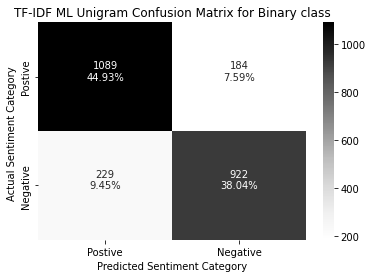

In [19]:
y_pred=clf.best_estimator_.predict(x_test)
y_pred = y_pred.reshape(-1,1)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greys')

ax.set_title('TF-IDF ML Unigram Confusion Matrix for Binary class');
ax.set_xlabel('Predicted Sentiment Category')
ax.set_ylabel('Actual Sentiment Category ');

ax.xaxis.set_ticklabels(['Postive', 'Negative'])
ax.yaxis.set_ticklabels(['Postive', 'Negative'])
sns.set(color_codes=True)
sns.set(font_scale=1.3)
plt.savefig('TF-IDF ML Unigram Confusion Matrix for Binary class', bbox_inches = "tight")
plt.show()

In [20]:
# TF-IDF Bigram
tfidf_bigram = TfidfVectorizer(ngram_range=(1,2),use_idf=True,tokenizer=lambda x: x.split()) 
x_tfidf_bigram = tfidf_bigram.fit_transform(df['Token'])
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_tfidf_bigram,df['Label'], test_size=0.2, random_state=42)

In [21]:
scores = []
for model_name, mp in model_params.items():
  for score in scores_function:
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, scoring=score)
    clf.fit(x_train,y_train)
    
  scores.append({
            'model': model_name,
            'best_params': clf.best_params_,
            'precision':precision_score(y_test,clf.predict(x_test),average='macro'),
            'recall':recall_score(y_test,clf.predict(x_test),average='macro'),
            'f1':f1_score(y_test,clf.predict(x_test),average='macro'),
            'accuracy':accuracy_score(y_test,clf.predict(x_test))
        })
    
df_score = pd.DataFrame(scores,columns=['model','best_params','precision','recall','f1','accuracy'])
df_score.to_excel('2 classes TF-IDF Bigram ML parameters.xlsx')
df_score.sort_values(by=['accuracy'],ascending=False) 


,model,best_params,precision,recall,f1,accuracy
3,multinomial naive bayes,{'alpha': 0.4},0.866660,0.864564,0.865254,0.865924
2,logistic_regression,{'C': 10},0.861416,0.859767,0.860342,0.860974
0,svm,"{'C': 1, 'decision_function_shape': 'ovo', 'ga...",0.856654,0.855363,0.855839,0.856436
5,Stochastic Gradient Descent,"{'alpha': 0.0001, 'loss': 'log', 'penalty': 'l2'}",0.840965,0.838195,0.838986,0.839934
4,k nearest neighbors,"{'algorithm': 'ball_tree', 'n_neighbors': 7, '...",0.811363,0.809535,0.810100,0.811056
1,decision tree,"{'criterion': 'entropy', 'max_depth': 900, 'ma...",0.729619,0.728847,0.729105,0.730198


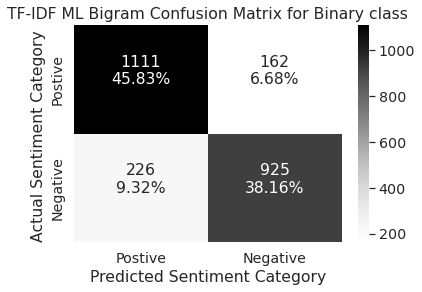

In [22]:
y_pred=clf.best_estimator_.predict(x_test)
y_pred = y_pred.reshape(-1,1)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greys')

ax.set_title('TF-IDF ML Bigram Confusion Matrix for Binary class');
ax.set_xlabel('Predicted Sentiment Category')
ax.set_ylabel('Actual Sentiment Category ');

ax.xaxis.set_ticklabels(['Postive', 'Negative'])
ax.yaxis.set_ticklabels(['Postive', 'Negative'])
sns.set(color_codes=True)
sns.set(font_scale=1.3)
plt.savefig('TF-IDF ML Bigram Confusion Matrix for Binary class', bbox_inches = "tight")
plt.show()

In [23]:
#TF-IDF Trigram
tfidf_trigram = TfidfVectorizer(ngram_range=(1,3),use_idf=True,tokenizer=lambda x: x.split()) 
x_tfidf_trigram = tfidf_trigram.fit_transform(df['Token'])
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_tfidf_trigram,df['Label'], test_size=0.2, random_state=42)

In [24]:
scores = []
for model_name, mp in model_params.items():
  for score in scores_function:
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, scoring=score)
    clf.fit(x_train,y_train)
    
  scores.append({
            'model': model_name,
            'best_params': clf.best_params_,
            'precision':precision_score(y_test,clf.predict(x_test),average='macro'),
            'recall':recall_score(y_test,clf.predict(x_test),average='macro'),
            'f1':f1_score(y_test,clf.predict(x_test),average='macro'),
            'accuracy':accuracy_score(y_test,clf.predict(x_test))
        })
    
df_score = pd.DataFrame(scores,columns=['model','best_params','precision','recall','f1','accuracy'])
df_score.to_excel('2 classes TF-IDF trigram ML parameters.xlsx')
df_score.sort_values(by=['accuracy'],ascending=False) 


,model,best_params,precision,recall,f1,accuracy
3,multinomial naive bayes,{'alpha': 0.4},0.864775,0.861749,0.862631,0.863449
0,svm,"{'C': 10, 'decision_function_shape': 'ovo', 'g...",0.861922,0.860118,0.860733,0.861386
2,logistic_regression,{'C': 5},0.859910,0.857345,0.858129,0.858911
5,Stochastic Gradient Descent,"{'alpha': 0.0001, 'loss': 'log', 'penalty': 'l2'}",0.845303,0.840445,0.841552,0.842822
4,k nearest neighbors,"{'algorithm': 'ball_tree', 'n_neighbors': 7, '...",0.805111,0.804162,0.804512,0.805281
1,decision tree,"{'criterion': 'entropy', 'max_depth': 900, 'ma...",0.744157,0.743656,0.741317,0.741337


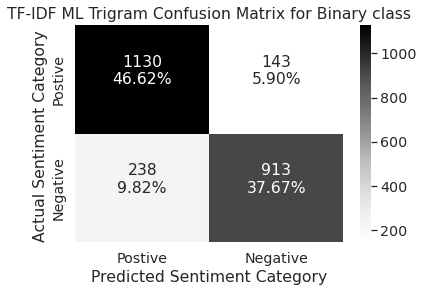

In [25]:
y_pred=clf.best_estimator_.predict(x_test)
y_pred = y_pred.reshape(-1,1)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greys')

ax.set_title('TF-IDF ML Trigram Confusion Matrix for Binary class');
ax.set_xlabel('Predicted Sentiment Category')
ax.set_ylabel('Actual Sentiment Category ');

ax.xaxis.set_ticklabels(['Postive', 'Negative'])
ax.yaxis.set_ticklabels(['Postive', 'Negative'])
sns.set(color_codes=True)
sns.set(font_scale=1.3)
plt.savefig('TF-IDF ML Trigram Confusion Matrix for Binary class', bbox_inches = "tight")
plt.show()